# Advanced optimization - Homework 2

## 1. Dataset introduction
- Thông tin cá nhân:
  - EmployeeNumber: Mã Nhân viên
  - Gender: giới tính: Female/ Male
  - Age: Tuổi
  - MaritalStatus: Tình trạng hôn nhân, bao gồm các trạng thái
      - Unknown
      - Married
      - Divorced
      - Single
      - Widowed
  - Education: Cấp bậc học vấn, bao gồm 5 cấp bậc:
      - 1: Phổ thông trung học
      - 2: Trung cấp/ cao đẳng
      - 3: Đại học
      - 4: Thạc sỹ
      - 5: Tiến sỹ
  - EducationField: chuyên ngành giáo dục, bao gồm các phân loại chuyên ngành:
      - Kinh tế
      - Kỹ thuật
      - Công nghệ
      - Ngôn ngữ
      - Other
  - School: thông tin trường học
- Thông về công việc:
  - Department: đơn vị làm việc
  - jobCategory: phân ngành công việc
  - JobLevel: cấp bậc của nhân viên => yếu tố đánh giá thu nhập của nhân viên, chia thành 5 cấp bậc xếp hạng từ 1 --> 5 (với 5 là cấp bậc cao)
- Thông tin về hiệu suất và gắn bó:
  - PerformanceRating: đánh giá hiệu quả công việc trong 3 tháng gần nhất, xếp hạng từ 1 --> 5 (với 5 mà đánh giá tốt)
  - YearsAtCompany: thâm niên tại công ty
- Biến phụ thuộc:
  - Attrition: Yes/No => có nghỉ việc hay không

## 2. Setup

### 2.0 Install libraries

In [181]:
# !pip install numpy
# !pip install pandas
# !pip install xlrd
# !pip install openpyxl
# !pip install seaborn

### 2.1 Import libaries

In [182]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import random
from enum import Enum
import time
import glob
import os
import ast
import scipy.special

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
random.seed(2)

### 2.2 Setup parameters

In [183]:
# FEATURES
# employee_number
# age                   : numerical
# department            : no oder categorical
# education             : order categorical
# school                : no oder categorical
# education_field       : no oder categorical
# gender                : no oder categorical
# job_level             : oder categorical
# job_title             : no oder categorical
# job_role              : no oder categorical
# job_category          : no oder categorical
# marital_status        : no oder categorical
# performance_rating    : order categorical
# years_at_company      : numerical

# OUTPUT
# attrition             : binary output

#### 2.2.1 Dataset parameters

In [184]:
DATASET_FILE_NAME = "hr_dataset.xlsx"
NUMERICAL_FEATURES = ["age", "years_at_company"]
ORDER_CATEGORICAL_FEATURES = ["education", "job_level", "performance_rating"]
NO_ORDER_CATEGORICAL_FEATURES = ["department", "school", "education_field", "gender", "job_category", "marital_status"]
OUTPUT_NAME = ["attrition"]

In [185]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ORDER_CATEGORICAL_FEATURES) + len(NO_ORDER_CATEGORICAL_FEATURES) + len(OUTPUT_NAME)
print("Total number of features: ", total_number_of_features)

Total number of features:  12


#### 2.2.2 GRADIENT DESCENT parameters

### 2.3 Import dataset

In [186]:
df = pd.read_excel(DATASET_FILE_NAME)

In [187]:
df

,Age,Department,Education,school,EducationField,Gender,JobLevel,jobCategory,MaritalStatus,PerformanceRating,YearsAtCompany,Attrition
0,30,FHO FWA,3,Đại học Duy Tân,Kỹ thuật,Male,4,BA,Single,3,3.169863,Yes
1,28,FI,3,Đại học Duy Tân,Công nghệ,Female,3,Tester,Single,3,6.049315,Yes
2,30,FHM,3,Đại học Huế - ĐH Khoa học,Công nghệ,Male,4,Engineer,Single,4,4.254795,Yes
3,28,FSG,3,Đại học Kinh tế quốc dân,Kinh tế,Female,3,BA,Single,3,3.835616,Yes
4,27,GST,3,Đại học Công nghệ Petronas,Công nghệ,Male,3,Engineer,Single,3,3.002740,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,SCM,3,Đại học Đà Nẵng - ĐH Sư phạm,Công nghệ,Male,3,Tester,Single,3,0.041096,No
4996,35,FQC,3,Đại học Kinh tế HCM,Kinh tế,Female,1,QA,Married,3,0.942466,No
4997,25,GST,3,Đại học QG Hà Nội-ĐH Công nghệ,Công nghệ,Male,1,Engineer,Single,3,1.372603,No
4998,25,FQC,3,Đại học Tôn Đức Thắng,Kinh tế,Male,2,QA,Single,3,1.191781,No


### 2.4 Overview of dataset

In [188]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def standardize_column_names(column_list):
    return [camel_to_snake(col) for col in column_list]

standardize_column_names(df.columns)

['age',
 'department',
 'education',
 'school',
 'education_field',
 'gender',
 'job_level',
 'job_category',
 'marital_status',
 'performance_rating',
 'years_at_company',
 'attrition']

In [189]:
df.columns = standardize_column_names(df.columns)

In [190]:
df.columns

Index(['age', 'department', 'education', 'school', 'education_field', 'gender',
       'job_level', 'job_category', 'marital_status', 'performance_rating',
       'years_at_company', 'attrition'],
      dtype='object')

<Axes: >

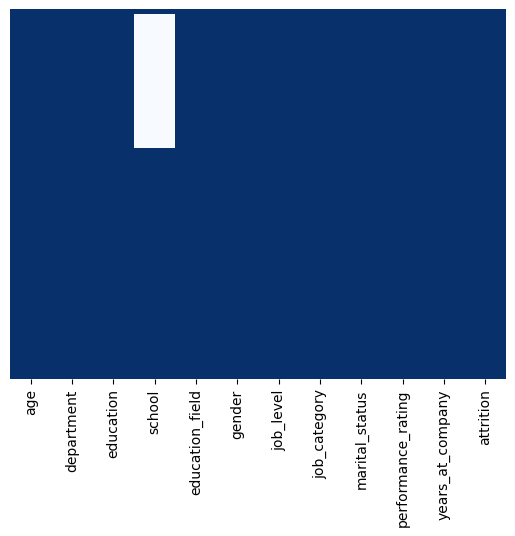

In [191]:
sns.heatmap(df.isnull(), cmap="Blues_r", cbar=False, yticklabels=False)

### 2.5 age

In [192]:
df["age"].describe()

count    5000.000000
mean       29.273800
std         4.876596
min        19.000000
25%        25.000000
50%        28.000000
75%        32.000000
max        54.000000
Name: age, dtype: float64

### 2.6 department

In [193]:
df["department"].describe()

count     4999
unique      57
top         FI
freq       651
Name: department, dtype: object

### 2.7 education

In [194]:
df["education"].describe()

count    5000.000000
mean        2.851800
std         0.509007
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: education, dtype: float64

## 3. Data cleaning

In [195]:
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)
cleaned_df

,age,education,job_level,performance_rating,years_at_company,attrition,department_AIC,department_CEP,department_DES,department_DPS,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,30,3,4,3,3.169863,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,28,3,3,3,6.049315,Yes,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,30,3,4,4,4.254795,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,28,3,3,3,3.835616,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,3,3,3,3.002740,Yes,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,No,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
4996,35,3,1,3,0.942466,No,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4997,25,3,1,3,1.372603,No,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4998,25,3,2,3,1.191781,No,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False


### 3.1 Data cleaning

In [196]:
# One hot encoding
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)

# Convert all boolean to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == np.bool_:
        cleaned_df[col] = cleaned_df[col].astype(int)

# Convert output
cleaned_df["attrition"] = cleaned_df["attrition"].map({"Yes": 1, "No": 0})

# Move output column to the last position
attrition_column = cleaned_df.pop("attrition")
cleaned_df = pd.concat([cleaned_df, attrition_column], axis=1)

cleaned_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,30,3,4,3,3.169863,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,3,3,3,6.049315,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,3,4,4,4.254795,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,28,3,3,3,3.835616,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,27,3,3,3,3.002740,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,35,3,1,3,0.942466,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,25,3,1,3,1.372603,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,25,3,2,3,1.191781,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### 3.2 Data standardization

In [197]:
cleaned_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,30,3,4,3,3.169863,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,3,3,3,6.049315,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,3,4,4,4.254795,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,28,3,3,3,3.835616,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,27,3,3,3,3.002740,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,3,3,3,0.041096,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,35,3,1,3,0.942466,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,25,3,1,3,1.372603,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,25,3,2,3,1.191781,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [198]:
scaler = StandardScaler()

scaled_df = cleaned_df.copy()
scaled_df[NUMERICAL_FEATURES] = scaler.fit_transform(scaled_df[NUMERICAL_FEATURES])

scaled_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,0.148930,3,4,3,-0.068547,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,-0.261233,3,3,3,0.813548,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0.148930,3,4,4,0.263812,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,-0.261233,3,3,3,0.135401,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,-0.466314,3,3,3,-0.119744,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.354012,3,3,3,-1.027018,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,1.174338,3,1,3,-0.750891,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,-0.876478,3,1,3,-0.619123,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,-0.876478,3,2,3,-0.674516,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### 3.3 Summary X and y

In [199]:
X_df = scaled_df.iloc[:,:-1]
X_df

,age,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,0.148930,3,4,3,-0.068547,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.261233,3,3,3,0.813548,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.148930,3,4,4,0.263812,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-0.261233,3,3,3,0.135401,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.466314,3,3,3,-0.119744,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.354012,3,3,3,-1.027018,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4996,1.174338,3,1,3,-0.750891,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4997,-0.876478,3,1,3,-0.619123,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4998,-0.876478,3,2,3,-0.674516,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [200]:
X = np.array(X_df).T
X

array([[ 0.14893024, -0.26123291,  0.14893024, ..., -0.87647764,
        -0.87647764, -1.28664079],
       [ 3.        ,  3.        ,  3.        , ...,  3.        ,
         3.        ,  3.        ],
       [ 4.        ,  3.        ,  4.        , ...,  1.        ,
         2.        ,  2.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [201]:
X.shape

(359, 5000)

In [202]:
y_df = scaled_df.iloc[:,-1]
y_df

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: attrition, Length: 5000, dtype: int64

In [203]:
y = np.array(y_df).reshape(-1, 1)
y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [204]:
y.shape

(5000, 1)

### 3.4 Build Xbar (X and bias)

In [205]:
one = np.ones((1, X.shape[1]))
Xbar = np.concatenate((one, X), axis=0)
Xbar

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.14893024, -0.26123291,  0.14893024, ..., -0.87647764,
        -0.87647764, -1.28664079],
       [ 3.        ,  3.        ,  3.        , ...,  3.        ,
         3.        ,  3.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [206]:
Xbar.shape

(360, 5000)

## 4. Build the models

### Requirements
- Neccessary features
- Best link functions

### 4.1. The simplest model

In [207]:
# y = f(w^Tx)

# f(s) = 1 / (1 + e^-s)     (logit link function)

In [208]:
def sigmoid(x):
    return scipy.special.expit(x)

## 5. Algorithms optimization

### 5.1. Loss function selection

In [209]:
"""
z = b + w * x

y^ = 1 / (1 + e^-z) (sigmoid link function)

cost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))

Conclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))

"""

'\nz = b + w * x\n\ny^ = 1 / (1 + e^-z) (sigmoid link function)\n\ncost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))\n\nConclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))\n\n'

In [210]:
def cost(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    
    return 1 / N * -(y.T.dot(np.log(y_hat)) + (1 - y).T.dot(np.log(1 - y_hat)))

In [211]:
"""
cost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))

Let A = y * log(y^)

Let B = (y - 1) * log(1 - y^)


Find dA/dw

dA/dw 
= d(y * log(y^)) / dw
= y * 1 / y^ * (dy^/dw)
= y * 1 / y^ * (dy^/dz * dz/dw)
= y * 1 / y^ * ((1 - y^) * y^ * x)
= y * (1 - y^) * x


Find dB/dw

dB/dw
= d((1 - y) * log(1 - y^)) / dw
= (1 - y) / (1 - y^) * (dy^/dw)
= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)
= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)
= (1 - y) * y^ * x

=> gradient(y^, y)
= dA/dw + dB/dw
= y * (1 - y^) * x + (1 - y) * y^ * x
= x * (y^ - y)

Conclusion: gradient(y^, y) = x * (y^ - y)

"""

'\ncost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))\n\nLet A = y * log(y^)\n\nLet B = (y - 1) * log(1 - y^)\n\n\nFind dA/dw\n\ndA/dw \n= d(y * log(y^)) / dw\n= y * 1 / y^ * (dy^/dw)\n= y * 1 / y^ * (dy^/dz * dz/dw)\n= y * 1 / y^ * ((1 - y^) * y^ * x)\n= y * (1 - y^) * x\n\n\nFind dB/dw\n\ndB/dw\n= d((1 - y) * log(1 - y^)) / dw\n= (1 - y) / (1 - y^) * (dy^/dw)\n= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)\n= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)\n= (1 - y) * y^ * x\n\n=> gradient(y^, y)\n= dA/dw + dB/dw\n= y * (1 - y^) * x + (1 - y) * y^ * x\n= x * (y^ - y)\n\nConclusion: gradient(y^, y) = x * (y^ - y)\n\n'

In [212]:
def grad(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    
    return Xbar.dot(y_hat - y) / N

In [213]:
"""
gradient_2(y^, y) 
= 1 / N * X^T * R * X

with R is diagonal matrix with Rii = y_hat(x^(i))(1 - y_hat(x^(i)))

"""

'\ngradient_2(y^, y) \n= 1 / N * X^T * R * X\n\nwith R is diagonal matrix with Rii = y_hat(x^(i))(1 - y_hat(x^(i)))\n\n'

In [214]:
def grad_2(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    R = np.diag(y_hat.flatten() * (1 - y_hat.flatten()))

    return Xbar.dot(R).dot(Xbar.T) / N

### 5.2. Double check gradient using numerical gradient

In [215]:
def check_grad(fn, gr, X, Xbar: np.ndarray, y: np.ndarray):
    # convert X to an 1d array, later we'll need only one for loop
    X_flat = X.ravel()
    shape_X = X.shape  # original shape of X
    num_grad = np.zeros_like(X)  # numerical grad, shape = shape of X
    grad_flat = np.zeros_like(X_flat)  # 1d version of grad
    eps = 1e-10  # a small number, 1e-10 -> 1e-8 is often good
    numElems = X_flat.shape[0]  # number of elements in X
    # calculate numerical gradient
    for i in range(numElems):  # iterate over all elements of X
        Xp_flat = X_flat.copy()
        Xn_flat = X_flat.copy()
        Xp_flat[i] += eps
        Xn_flat[i] -= eps
        Xp = Xp_flat.reshape(shape_X)
        Xn = Xn_flat.reshape(shape_X)
        fp_ = fn(Xp, Xbar, y)
        fn_ = fn(Xn, Xbar, y)
        grad_flat[i] = (fp_.item() - fn_.item()) / (2 * eps)

    num_grad = grad_flat.reshape(shape_X)

    diff = np.linalg.norm(num_grad.reshape(-1, 1) - gr(X, Xbar, y).reshape(-1, 1))
    print("Difference between two methods should be small:", diff)


# check_grad(cost, grad, np.array([0] * Xbar.shape[0]), Xbar, y)

In [216]:
# check_grad(cost, grad, np.array([0.1] * Xbar.shape[0]), Xbar, y)

check_grad(cost, grad, np.random.randn(Xbar.shape[0]), Xbar, y)

Difference between two methods should be small: 1.1118686773880562e-05


### 5.3. Core functions

In [217]:
W_EPOCH = []
EPOCH_COUNT = []
LOSS_VALUE_EPOCH = []
TIME_EACH_EPOCH = []


def reset_list():
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, TIME_EACH_EPOCH

    W_EPOCH = []
    EPOCH_COUNT = []
    LOSS_VALUE_EPOCH = []
    TIME_EACH_EPOCH = []


class AlgorithmType(Enum):
    """Enumeration for different algorithm types with optional parameters."""

    # INCLUDED ADDITIONAL PARAMETERS

    # GRADIENT_DESCENT =================================================

    GRADIENT_DESCENT_FIX_LEARNING_RATE = {}
    """Gradient Descent with a fixed learning rate. No additional parameters."""

    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {"alpha": 1 / 4, "beta": 1 / 2}
    """Gradient Descent with backtracking line search.
    
    Parameters:
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # STOCHASTIC_GRADIENT_DESCENT ======================================

    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
    }
    """Stochastic Gradient Descent with a diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
    """

    STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Stochastic Gradient Descent with a backtracking diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # MOMENTUM_GRADIENT_DESCENT ========================================

    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"gamma": 0.9}
    """Momentum Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: weight of previous velocity.
    """

    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Momentum Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # NESTEROV_GRADIENT_DESCENT ========================================

    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"NAG_gamma": 0.9}
    """Nesterov Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
    """

    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "NAG_gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Nesterov Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    NEWTON = {"test": 1}
    """Newton algorithm
    
    Parameters:
        test: to distinguish with GRADIENT_DESCENT_FIX_LEARNING_RATE
    """


# GRADIENT_DESCENT_FIX_LEARNING_RATE
def gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        w_new = W_EPOCH[-1] - learning_rate * grad(W_EPOCH[-1], Xbar, y)

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    # Additional parameters
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        learning_rate = initial_learning_rate

        # BACKTRACKING =================================================

        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        # ==============================================================

        w_new = W_EPOCH[-1] - learning_rate * grad(W_EPOCH[-1], Xbar, y)

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            w_each_iteration = [W_EPOCH[-1]]

            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w_each_iteration[-1] - initial_learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )

                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Cyclic rule
    elif rule == 1:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        original_all_indexes = list(range(Xbar.shape[1]))
        random.shuffle(original_all_indexes)

        for epoch in range(max_epochs):
            all_indexes = original_all_indexes.copy()
            selected_indexes = []
            iteration = 0
            w_each_iteration = [W_EPOCH[-1]]

            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w_each_iteration[-1] - initial_learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )

                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_backtracking_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        w_each_iteration = [w0]
        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w_each_iteration[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w_each_iteration[-1] - learning_rate * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )
                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Cyclic rule
    elif rule == 1:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        w_each_iteration = [w0]
        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w_each_iteration[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w_each_iteration[-1] - learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )
                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
def momentum_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v_old = np.zeros_like(w0)

    start_time = time.time()

    for epoch in range(max_epochs):

        v_new = gamma * v_old + initial_learning_rate * grad(W_EPOCH[-1], Xbar, y)
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v_old = v_new

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def momentum_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v_old = np.zeros_like(w0)

    start_time = time.time()

    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v_old + learning_rate * grad(W_EPOCH[-1], Xbar, y)
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v_old = v_new

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
def nesterov_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["NAG_gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v = [np.zeros_like(w0)]

    start_time = time.time()

    for epoch in range(max_epochs):

        v_new = gamma * v[-1] + initial_learning_rate * grad(
            W_EPOCH[-1] - gamma * v[-1], Xbar, y
        )
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v.append(v_new)

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def nesterov_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["NAG_gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v = [np.zeros_like(w0)]

    start_time = time.time()

    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v[-1] + learning_rate * grad(
            W_EPOCH[-1] - gamma * v[-1], Xbar, y
        )
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v.append(v_new)

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NEWTON
def newton(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    grad_2,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-8,
    additional_parameters=AlgorithmType.NEWTON.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        "w+ = w - (f''(w))^-1 * f'(w)"

        w_new = W_EPOCH[-1] - np.linalg.pinv(grad_2(W_EPOCH[-1], Xbar, y)).dot(
            grad(W_EPOCH[-1], Xbar, y)
        )

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


def calculate_loss_value(cost, w1: list, Xbar: np.ndarray, y: np.ndarray):
    loss_value = []
    for index in range(len(w1)):
        loss_value.append(cost(w1[index], Xbar, y).item())

    return loss_value


def snapshot_w(time_step: float):
    global W_TIME, TIME, RUNNING

    W_TIME = [W_EPOCH[0]]
    TIME = [0]

    start_time = time.time()
    last_time = time.time()
    current_time = time.time()

    while RUNNING.is_set():
        current_time = time.time()
        if current_time - last_time > time_step:
            W_TIME.append(W_EPOCH[-1])
            TIME.append(current_time - start_time)
            last_time = current_time


def plot(
    x: list,
    y: str,
    xlabel: str,
    ylabel: str,
    title: str,
):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def one_for_all(
    algorithm_type: AlgorithmType,
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    initial_w: np.ndarray,
    initial_learning_rate: np.ndarray,
    algorithm_name: str,
    max_epochs=1000,
    eps=1e-8,
    additional_parameters=None,
    grad_2=None,
):
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, TIME_EACH_EPOCH

    reset_list()

    match algorithm_type:

        case AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE:
            gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
            )

        case AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE:
            stochastic_gradient_descent_diminishing_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case (
            AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
        ):
            stochastic_gradient_descent_backtracking_diminishing_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            momentum_gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            momentum_gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            nesterov_gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            nesterov_gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NEWTON:
            newton(
                Xbar,
                y,
                cost,
                grad,
                grad_2,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

    LOSS_VALUE_EPOCH = calculate_loss_value(cost, W_EPOCH, Xbar, y)

    print(f"{algorithm_name}")
    print(f"Best loss values: {LOSS_VALUE_EPOCH[-1]:.6f}")
    
    if (algorithm_type != AlgorithmType.NEWTON):
        print(f"Initial learning rate: {initial_learning_rate}")
        
    print(f"Number of epochs ran/Max epoches: {EPOCH_COUNT[-1] - 1}/{max_epochs}")
    print(f"Runtime: {TIME_EACH_EPOCH[-1]:.6f} seconds")
    print(f"Additional parameters: {additional_parameters}")

    plot(
        EPOCH_COUNT,
        LOSS_VALUE_EPOCH,
        "Epoches",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along EPOCHES",
    )

    plot(
        TIME_EACH_EPOCH,
        LOSS_VALUE_EPOCH,
        "Time (seconds)",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along TIME",
    )

    return (W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH, LOSS_VALUE_EPOCH)

In [218]:
class Result:
    def __init__(self):
        pass

    def add_parameter(
        self,
        algorithm_type: AlgorithmType,
        initial_w: np.ndarray,
        initial_learning_rate: np.ndarray,
        max_epochs: int = 1000,
        eps: float = 1e-8,
        additional_parameters: dict = {},
    ):
        self.algorithm_type = algorithm_type.name
        self.initial_w = initial_w.tolist()
        self.initial_learning_rate = initial_learning_rate
        self.max_epochs = max_epochs
        self.eps = eps
        self.additional_parameters = additional_parameters
        self.best_loss_value = 0.0

    def add_one_for_all_result(self, one_for_all_result):
        self.w_solution = one_for_all_result[0][-1].tolist()
        self.epoch_list = one_for_all_result[1]
        self.time_each_epoch_list = one_for_all_result[2]
        self.loss_value_epoch_list = one_for_all_result[3]

        self.runtime = self.time_each_epoch_list[-1]
        self.epoch_count = self.epoch_list[-1] - 1
        self.best_loss_value = self.loss_value_epoch_list[-1]


class ResultSet:
    def __init__(self):
        self.list_result: list[Result] = []
        self.dataframe: pd.DataFrame = pd.DataFrame(
            columns=[
                "id",
                "algorithm_type",
                "initial_w",
                "initial_learning_rate",
                "max_epochs",
                "eps",
                "additional_parameters",
                "w_solution",
                "epoch_list",
                "time_each_epoch_list",
                "loss_value_epoch_list",
                "runtime",
                "epoch_count",
                "best_loss_value",
            ]
        )

    def add_result(self, result: Result):
        result.id = len(self.list_result)
        self.list_result.append(result)

    def reset_dataframe(self):
        self.dataframe: pd.DataFrame = pd.DataFrame(
            columns=[
                "id",
                "algorithm_type",
                "initial_w",
                "initial_learning_rate",
                "max_epochs",
                "eps",
                "additional_parameters",
                "w_solution",
                "epoch_list",
                "time_each_epoch_list",
                "loss_value_epoch_list",
                "runtime",
                "epoch_count",
                "best_loss_value",
            ]
        )

    def compile_dataframe(self):
        self.reset_dataframe()

        for result in self.list_result:
            self.dataframe.loc[len(self.dataframe)] = [
                result.id,
                result.algorithm_type,
                result.initial_w,
                result.initial_learning_rate,
                result.max_epochs,
                result.eps,
                result.additional_parameters,
                result.w_solution,
                result.epoch_list,
                result.time_each_epoch_list,
                result.loss_value_epoch_list,
                result.runtime,
                result.epoch_count,
                result.best_loss_value,
            ]

    def save_dataframe(self, file_name: str):
        self.dataframe.to_csv(file_name + ".csv", index=False)

In [219]:
result_set = ResultSet()

### 5.4. GRADIENT_DESCENT_FIX_LEARNING_RATE

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.129646
Initial learning rate: 0.6
Number of epochs ran/Max epoches: 15000/15000
Runtime: 21.087221 seconds
Additional parameters: {}


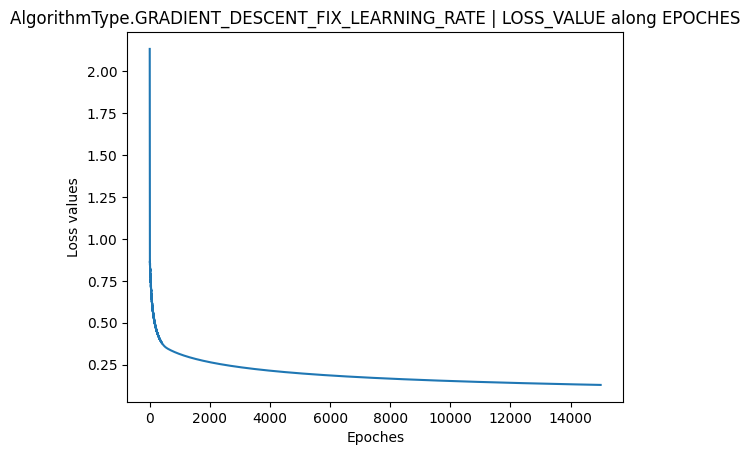

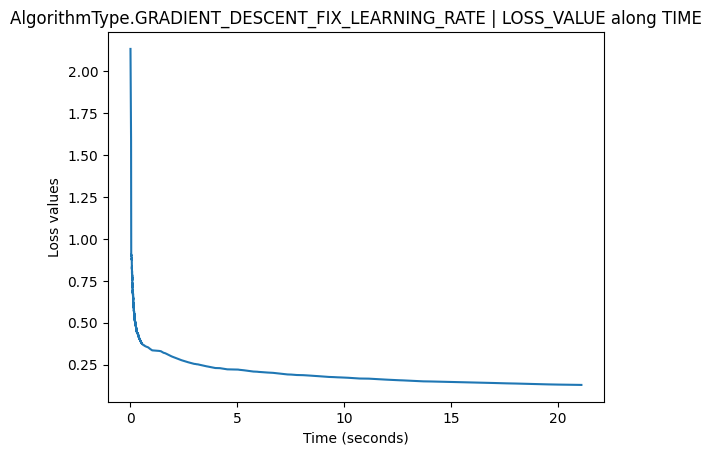

In [220]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.6
MAX_EPOCHS = 15000

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.5. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.572825
Initial learning rate: 1
Runtime: 99.964063 seconds
Additional parameters: {'alpha': 0.15, 'beta': 0.9}


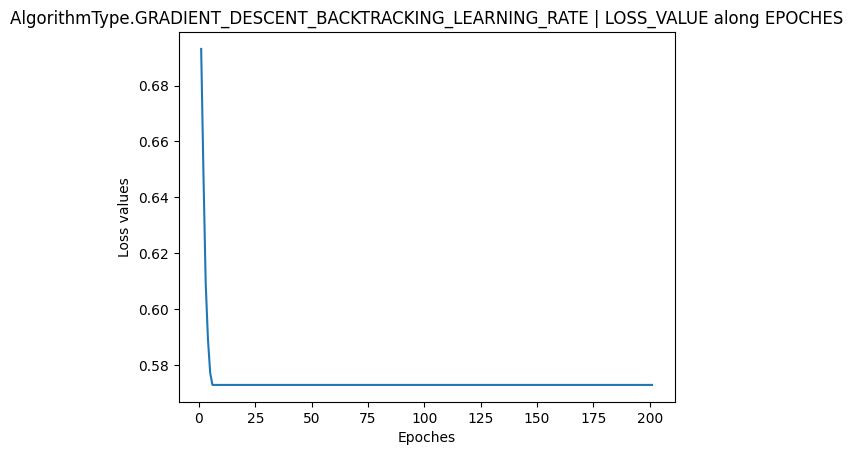

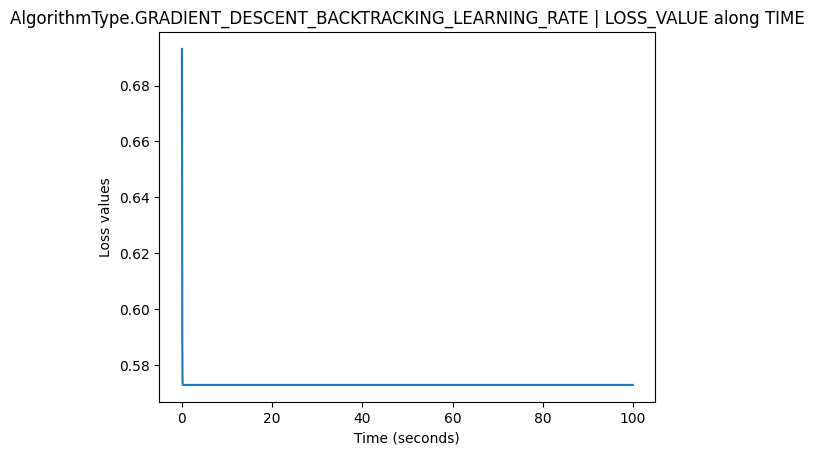

In [396]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200

ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA


result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.6. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - randomized

STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Best loss values: 0.425213
Initial learning rate: 0.03
Number of epochs ran/Max epoches: 187/500
Runtime: 21.819120 seconds
Additional parameters: {'batch_size': 1, 'rule': 0, 'random_seed': 10}


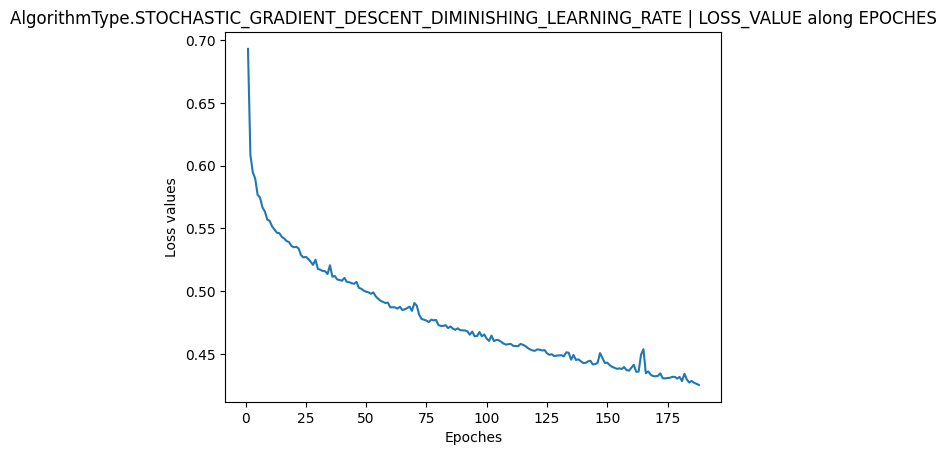

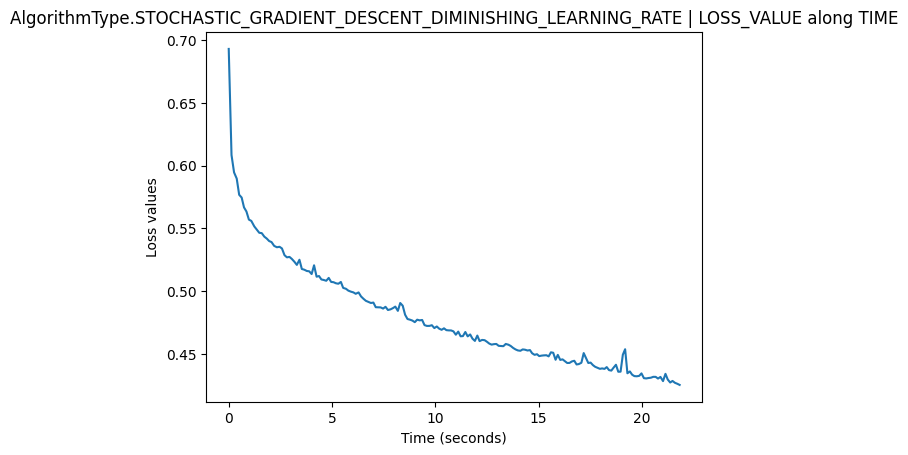

In [78]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.03
MAX_EPOCHS = 500

BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.7. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - cyclic

STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Best loss values: 0.230019
Initial learning rate: 1
Runtime: 46.195798 seconds
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}


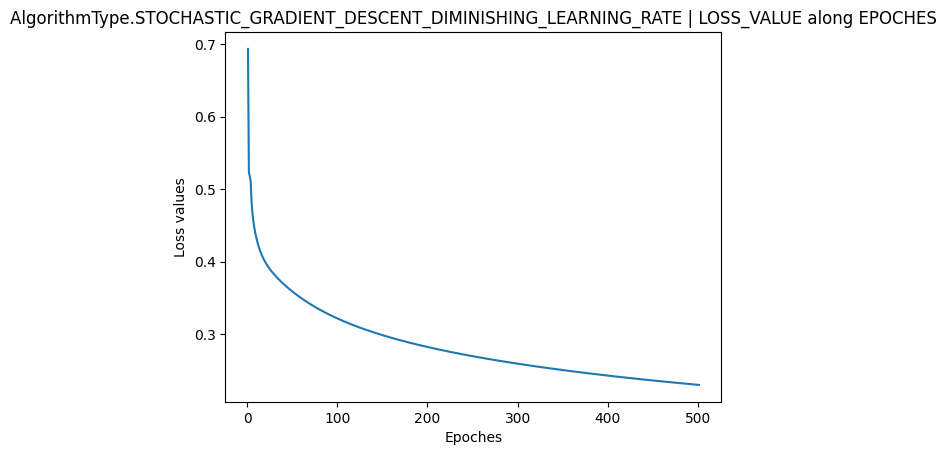

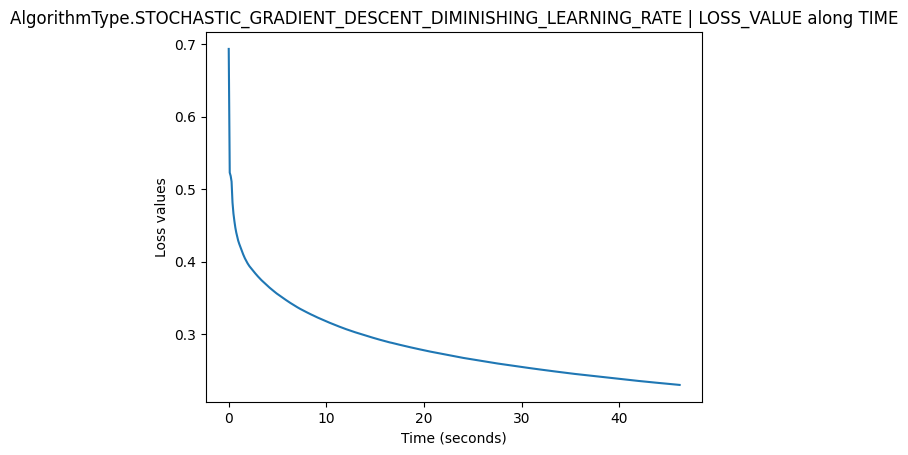

In [400]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500

BATCH_SIZE = 1
RULE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.8. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - randomized

STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
Best loss values: 0.566784
Initial learning rate: 1
Runtime: 39.409638 seconds
Additional parameters: {'batch_size': 500, 'rule': 0, 'random_seed': 10, 'alpha': 0.15, 'beta': 0.9}


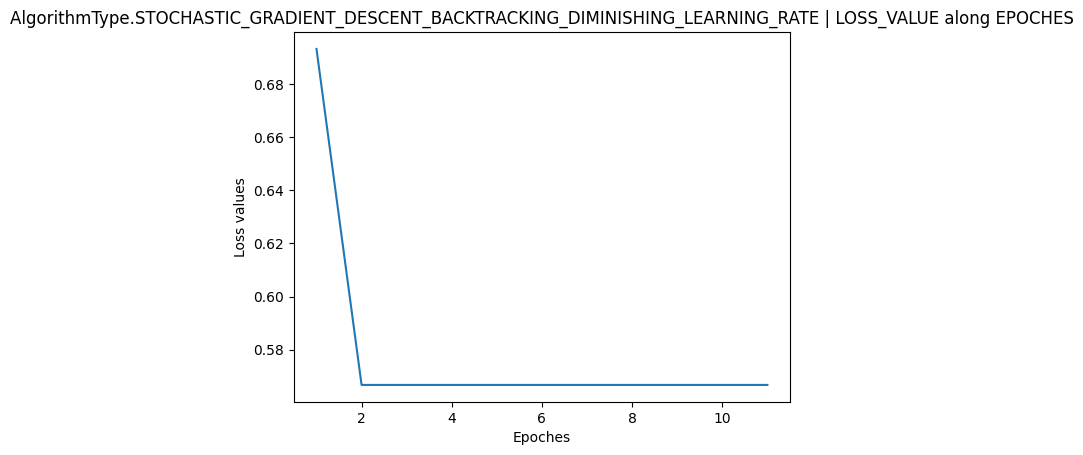

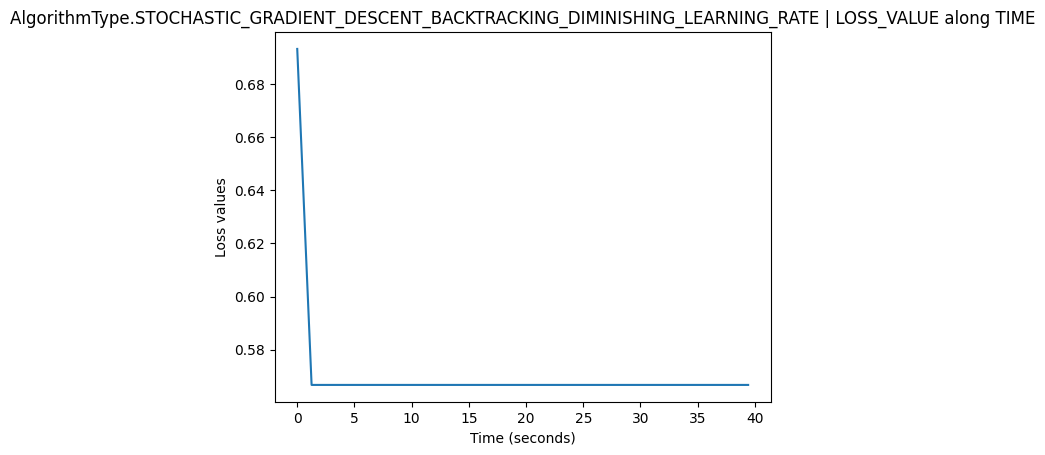

In [402]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 10

BATCH_SIZE = 500
RULE = 0
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.9. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - cyclic

STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
Best loss values: 0.576352
Initial learning rate: 1
Runtime: 21.703707 seconds
Additional parameters: {'batch_size': 500, 'rule': 1, 'random_seed': 10, 'alpha': 0.25, 'beta': 0.8}


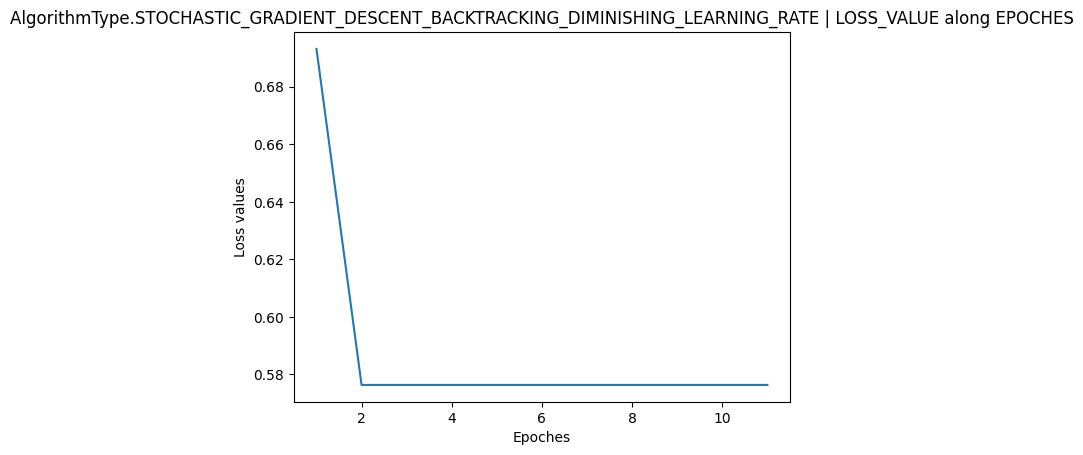

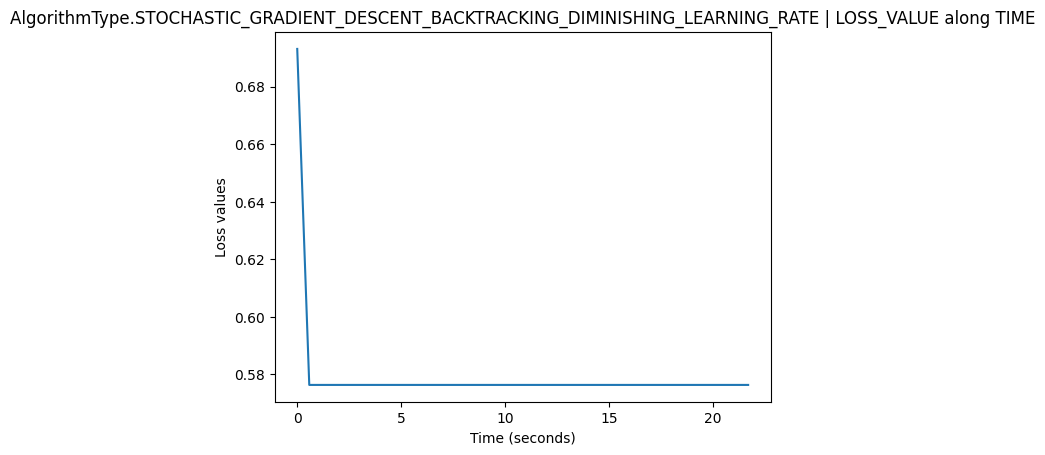

In [403]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 10

BATCH_SIZE = 500
RULE = 1
RANDOM_SEED = 10
ALPHA = 0.25
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.10. MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.410819
Initial learning rate: 1
Runtime: 0.114702 seconds
Additional parameters: {'gamma': 0.9}


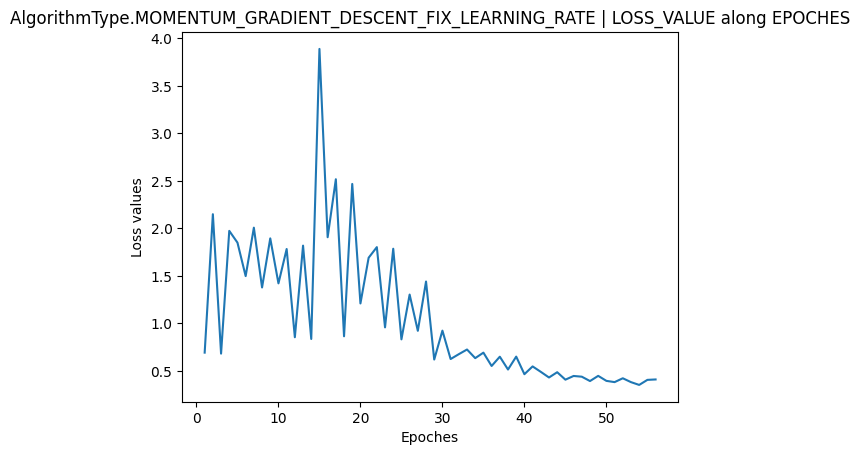

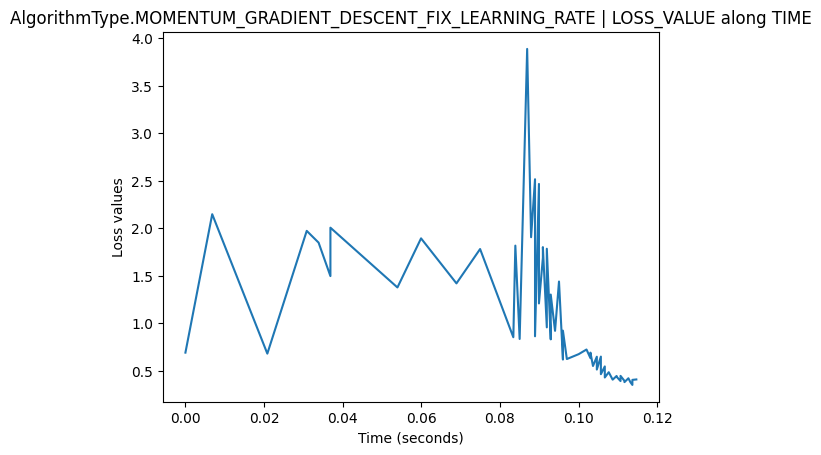

In [404]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.11. MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.564613
Initial learning rate: 1
Runtime: 42.110039 seconds
Additional parameters: {'gamma': 0.6, 'alpha': 0.3, 'beta': 0.5}


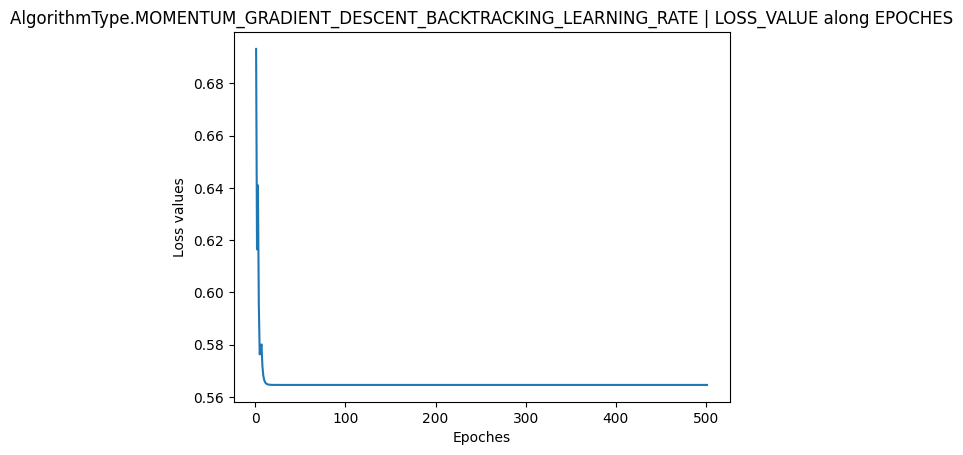

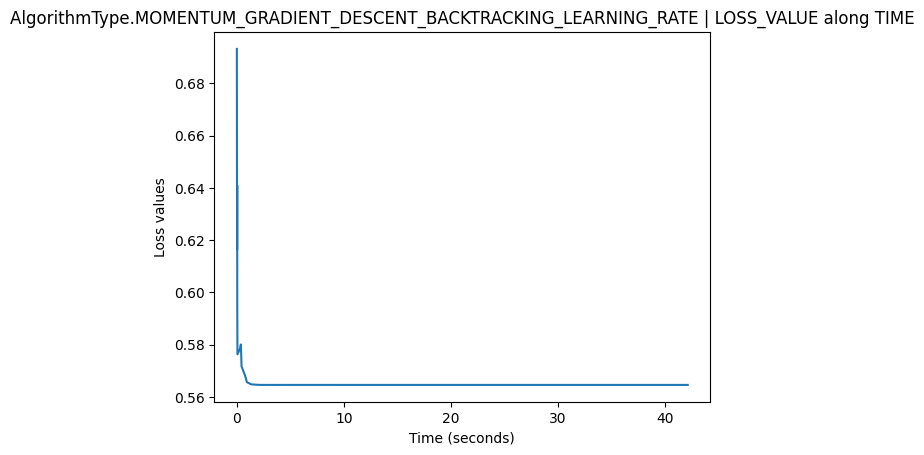

In [406]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500

GAMMA = 0.6
ALPHA = 0.3
BETA = 0.5

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.12. NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.216348
Initial learning rate: 0.5
Runtime: 0.530998 seconds
Additional parameters: {'NAG_gamma': 0.9}


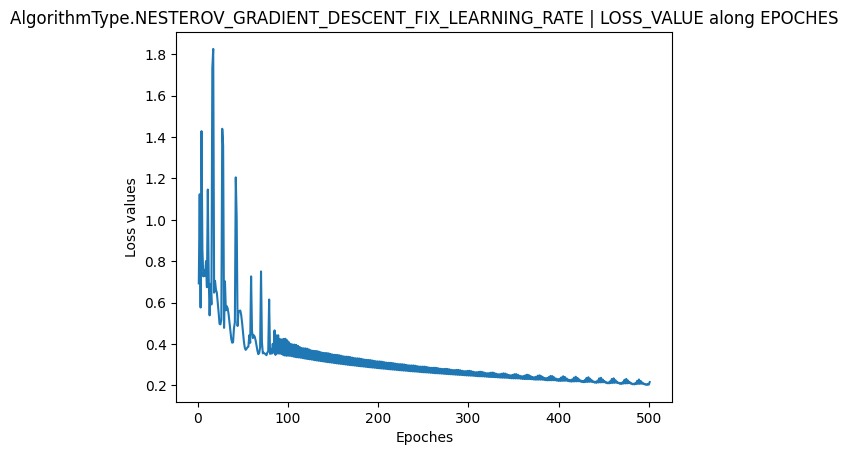

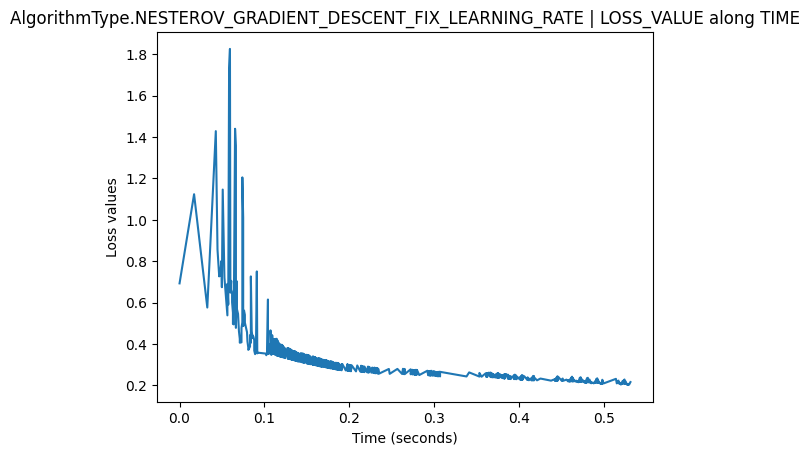

In [408]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 500

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.13. NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.568214
Initial learning rate: 0.5
Runtime: 19.498674 seconds
Additional parameters: {'NAG_gamma': 0.8, 'alpha': 0.5, 'beta': 0.8}


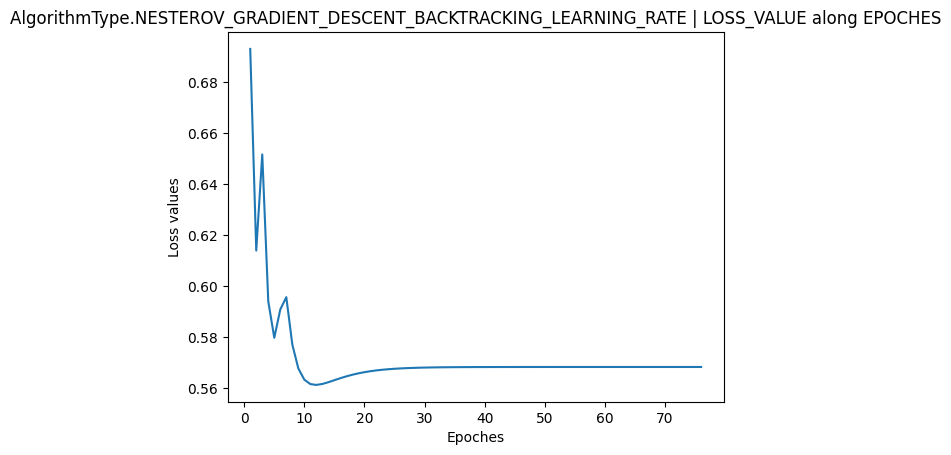

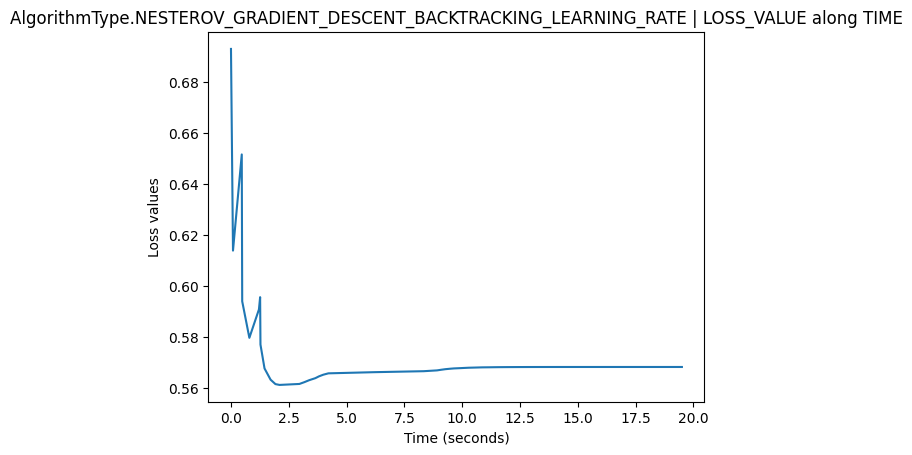

In [410]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 75

GAMMA = 0.8
ALPHA = 0.5
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.14. NEWTON

NEWTON
Best loss values: 0.076025
Number of epochs ran/Max epoches: 2/500
Runtime: 0.571967 seconds
Additional parameters: {'test': 1}


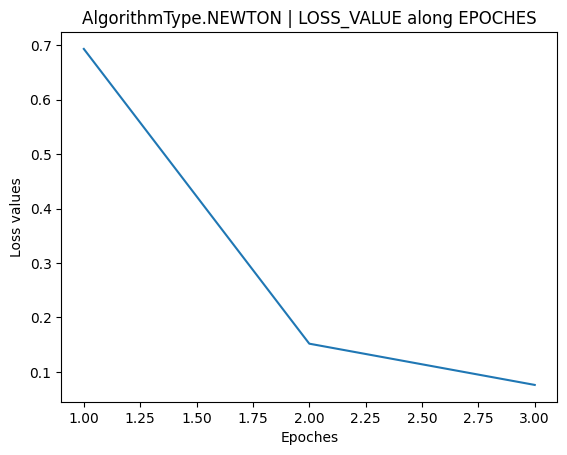

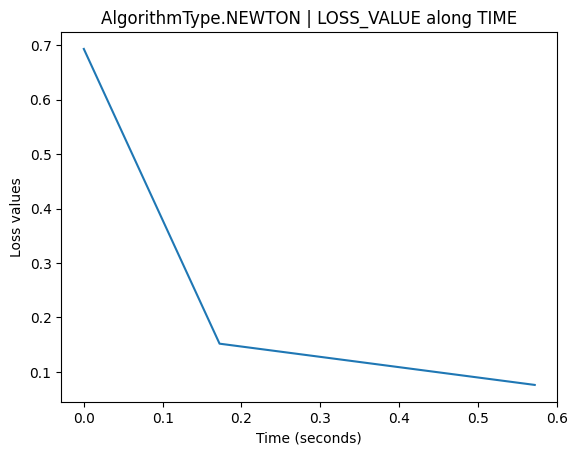

In [182]:
ALGORITHM_TYPE = AlgorithmType.NEWTON
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
MAX_EPOCHS = 500

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        additional_parameters=ADDITIONAL_PARAMETERS,
        grad_2=grad_2,
    )
)

result_set.add_result(result)

## 6. Save and load ResultSets

### 6.1 Save

In [318]:
result_set.compile_dataframe()
result_set.dataframe

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.23,15000,0.0001,{},"[[2.3061920294400973], [0.491527885491949], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.016074419021606445, 0.01908254623413086,...","[0.6931471805599466, 2.6403091784287294, 3.802...",18.648317,12044,0.097012


In [319]:
result_set.save_dataframe("test")

### 6.2 Load

In [355]:
LOADED_DATAFRAME = []

In [356]:
FOLDER_PATH = "./result/"

In [357]:
def load_result_from_folder(folder_path: str):
    if not os.path.isdir(FOLDER_PATH):
        raise Exception("Input path is not a directory!")
    
    global LOADED_DATAFRAME
    
    excel_files = glob.glob(folder_path + "*.xlsx")
    
    dfs = []
    
    for file in excel_files:
        df = pd.read_excel(file)
        dfs.append(df)
    
    LOADED_DATAFRAME = pd.concat(dfs, ignore_index=True)
    
    LOADED_DATAFRAME

In [358]:
load_result_from_folder(FOLDER_PATH)

In [359]:
LOADED_DATAFRAME

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,0,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.10,30,0.0001,"{'batch_size': 500, 'rule': 0, 'random_seed': ...","[[0.014997855889842126], [0.04314112120978633]...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 2.986870527267456, 12.38873291015625, 19.1...","[0.6931471805599457, 0.575783736501429, 0.5757...",302.624465,30,0.575784
1,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
2,2,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.23,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
3,3,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.24,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
4,4,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.25,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,182,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.54,500,0.0001,{'gamma': 0.95},"[[6.089420243491942], [-0.25566307057734033], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.01669621467590332, 0.0166...","[0.6931471805599447, 3.297136559095785, 0.8670...",0.175367,87,0.630151
167,151,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.20,500,0.0001,{'gamma': 0.95},"[[5.83989830129347], [0.2906047310925616], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.003498077392578125, 0.0034980773925...","[0.6931471805599447, 4.640388403920093, 1.1087...",0.404406,227,0.703367
168,150,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.10,500,0.0001,{'gamma': 0.95},"[[6.340672013872833], [-0.01792167055219107], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0067157745361328125, 0.00877332687377929...","[0.6931471805599447, 4.442861241069791, 1.0712...",0.199656,112,0.767904
169,153,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.40,500,0.0001,{'gamma': 0.95},"[[6.7869546401114125], [0.4412451780252754], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.00850987434387207, 0.00850987434387...","[0.6931471805599447, 5.026758661614779, 1.1834...",0.459596,244,0.828979


## 7. SKLEARN: SGDClassifier | log loss

In [203]:
NUMBER_OF_EPOCHS = 100
INITIAL_LEARNING_RATE = 0.005

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=100,
    tol=None,
    random_state=42,
    warm_start=True,
)

sklearn_SGDClassifier_model_time_array_log_loss_values = []

sklearn_SGDClassifier_model_time_array = [0]
start_time = time.time()
time_step = 1

sklearn_SGDClassifier_model_epoch_count = [1]
for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    sklearn_SGDClassifier_model_time_array_log_loss_values.append(loss)

    current_time = time.time()
    if current_time - start_time >= time_step:
        sklearn_SGDClassifier_model_time_array.append(current_time - start_time)

    sklearn_SGDClassifier_model_epoch_count.append(
        sklearn_SGDClassifier_model_epoch_count[-1] + 1
    )

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {sklearn_SGDClassifier_model_time_array_log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot loss value along epoch
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), sklearn_SGDClassifier_model_time_array_log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

# Plot loss value along time
limit = min(len(sklearn_SGDClassifier_model_time_array), len(sklearn_SGDClassifier_model_time_array_log_loss_values))
plt.plot(sklearn_SGDClassifier_model_time_array[:limit], sklearn_SGDClassifier_model_time_array_log_loss_values[:limit], marker="*")
plt.xlabel("Time")
plt.ylabel("Loss value")
plt.title(f"Sklearn - SGDClassifier")
plt.show()

In [204]:
# NUMBER_OF_EPOCHS = 1000
# INITIAL_LEARNING_RATE = 0.01

# X_fit = X.T

# sklearn_SGDClassifier_model = SGDClassifier(
#     loss="log_loss",
#     learning_rate="constant",
#     eta0=INITIAL_LEARNING_RATE,
#     max_iter=1,
#     tol=None,
#     random_state=42,
#     warm_start=True,
# )

# log_loss_values = []


# start_time = time.time()

# for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
#     sklearn_SGDClassifier_model.fit(X_fit, y)
#     y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
#     loss = log_loss(y, y_prob)
#     log_loss_values.append(loss)

# end_time = time.time()

# # Print result
# print(f"{sklearn_SGDClassifier_model}")
# print(f"Loss value: {log_loss_values[-1]:.6f}")
# print(f"Runtime: {(end_time - start_time):.6f} s")

# # Plot the loss curve
# plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
# plt.xlabel("Epoch")
# plt.ylabel("Loss value")
# plt.title(
#     f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
# )
# plt.show()

In [205]:
# NUMBER_OF_EPOCHS = 1000
# INITIAL_LEARNING_RATE = 0.02

# X_fit = X.T

# sklearn_SGDClassifier_model = SGDClassifier(
#     loss="log_loss",
#     learning_rate="constant",
#     eta0=INITIAL_LEARNING_RATE,
#     max_iter=1,
#     tol=None,
#     random_state=42,
#     warm_start=True,
# )

# log_loss_values = []


# start_time = time.time()

# for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
#     sklearn_SGDClassifier_model.fit(X_fit, y)
#     y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
#     loss = log_loss(y, y_prob)
#     log_loss_values.append(loss)

# end_time = time.time()

# # Print result
# print(f"{sklearn_SGDClassifier_model}")
# print(f"Loss value: {log_loss_values[-1]:.6f}")
# print(f"Runtime: {(end_time - start_time):.6f} s")

# # Plot the loss curve
# plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
# plt.xlabel("Epoch")
# plt.ylabel("Loss value")
# plt.title(
#     f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
# )
# plt.show()

In [206]:
# NUMBER_OF_EPOCHS = 1000
# INITIAL_LEARNING_RATE = 0.05

# X_fit = X.T

# sklearn_SGDClassifier_model = SGDClassifier(
#     loss="log_loss",
#     learning_rate="constant",
#     eta0=INITIAL_LEARNING_RATE,
#     max_iter=1,
#     tol=None,
#     random_state=42,
#     warm_start=True,
# )

# log_loss_values = []


# start_time = time.time()

# for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
#     sklearn_SGDClassifier_model.fit(X_fit, y)
#     y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
#     loss = log_loss(y, y_prob)
#     log_loss_values.append(loss)

# end_time = time.time()

# # Print result
# print(f"{sklearn_SGDClassifier_model}")
# print(f"Loss value: {log_loss_values[-1]:.6f}")
# print(f"Runtime: {(end_time - start_time):.6f} s")

# # Plot the loss curve
# plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
# plt.xlabel("Epoch")
# plt.ylabel("Loss value")
# plt.title(
#     f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
# )
# plt.show()

In [207]:
# NUMBER_OF_EPOCHS = 1000
# INITIAL_LEARNING_RATE = 0.1

# X_fit = X.T

# sklearn_SGDClassifier_model = SGDClassifier(
#     loss="log_loss",
#     learning_rate="constant",
#     eta0=INITIAL_LEARNING_RATE,
#     max_iter=1,
#     tol=None,
#     random_state=42,
#     warm_start=True,
# )

# log_loss_values = []


# start_time = time.time()

# for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
#     sklearn_SGDClassifier_model.fit(X_fit, y)
#     y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
#     loss = log_loss(y, y_prob)
#     log_loss_values.append(loss)

# end_time = time.time()

# # Print result
# print(f"{sklearn_SGDClassifier_model}")
# print(f"Loss value: {log_loss_values[-1]:.6f}")
# print(f"Runtime: {(end_time - start_time):.6f} s")

# # Plot the loss curve
# plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
# plt.xlabel("Epoch")
# plt.ylabel("Loss value")
# plt.title(
#     f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
# )
# plt.show()

In [208]:
# ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 500
# EPS = 1e-8

# GAMMA = 0.9
# ALPHA = 0.3
# BETA = 0.5

# # ADDITIONAL PARAMETERS
# ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

# ADDITIONAL_PARAMETERS["gamma"] = GAMMA
# ADDITIONAL_PARAMETERS["alpha"] = ALPHA
# ADDITIONAL_PARAMETERS["beta"] = BETA

# (
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
# ) = one_for_all(
#     algorithm_type=ALGORITHM_TYPE,
#     Xbar=Xbar,
#     y=y,
#     cost=cost,
#     grad=grad,
#     initial_w=INITIAL_W,
#     initial_learning_rate=INITIAL_LEARNING_RATE,
#     algorithm_name=ALGORITHM_TYPE,
#     max_epochs=MAX_EPOCHS,
#     eps=EPS,
#     marker="*",
#     additional_parameters=ADDITIONAL_PARAMETERS,
# )

## 8. Extract dataframes

### 8.1. GRADIENT_DESCENT_FIX_LEARNING_RATE

In [209]:
GRADIENT_DESCENT_FIX_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE.name
]

GRADIENT_DESCENT_FIX_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
2,2,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.23,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
3,3,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.24,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
4,4,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.25,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
5,5,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,15000,0.0001,{},"[[0.2850186693679891], [0.4929879568449873], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003034353256225586, 0.004045486450195312...","[0.6931471805599457, 0.6614799933659268, 0.598...",0.286542,212,0.434708
6,6,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.90,15000,0.0001,{},"[[0.2850186693679891], [0.4929879568449873], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003034353256225586, 0.004045486450195312...","[0.6931471805599457, 0.6614799933659268, 0.598...",0.286542,212,0.434708
7,7,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.50,15000,0.0001,{},"[[0.2850186693679891], [0.4929879568449873], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003034353256225586, 0.004045486450195312...","[0.6931471805599457, 0.6614799933659268, 0.598...",0.286542,212,0.434708
8,8,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.20,15000,0.0001,{},"[[0.2850186693679891], [0.4929879568449873], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003034353256225586, 0.004045486450195312...","[0.6931471805599457, 0.6614799933659268, 0.598...",0.286542,212,0.434708


### 8.2. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

In [210]:
GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.name
]

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
1,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
9,9,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.0,1000,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[-0.009712379018024256], [-0.0267674928753294...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.037689924240112305, 0.06289386749267578,...","[0.6931471805599457, 0.6202991087435373, 0.606...",439.630539,1000,0.606029
10,10,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.0,1000,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[-0.002804521857571268], [-0.0065755797899473...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.044306039810180664, 0.07853293418884277,...","[0.6931471805599457, 0.6202991087435373, 0.599...",395.099135,1000,0.599184
13,13,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.0,1000,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[-0.012581744553745743], [-0.0352287061552347...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.08929109573364258, 0.1985304355621338, 1...","[0.6931471805599457, 0.6175806616293461, 0.611...",1163.150544,1000,0.611010


### 8.3. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE

In [211]:
STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE.name
]

STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
11,11,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.50,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.0408195155165125], [0.4680916670668622], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.05300641059875488, 0.0944972038269043, 0...","[0.6931471805599457, 0.4949611332911349, 0.453...",347.468290,6854,0.075520
12,12,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.10,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[2.967360371697842], [0.46654589791233586], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.05640745162963867, 0.11662459373474121, ...","[0.6931471805599457, 0.5024100901317191, 0.463...",304.871733,6501,0.081277
14,14,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.03,500,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[0.34220294223566766], [0.48721507543194265],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.38142919540405273, 0.8598041534423828, 1...","[0.6931471805599457, 0.6085488758653587, 0.594...",59.391643,187,0.425213
15,15,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.20,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[3.647867592056637], [0.7482293968286783], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.32059383392333984, 0.6437911987304688, 1...","[0.6931471805599457, 0.4918153546941686, 0.577...",27.244124,84,0.288500
16,16,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.20,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[1.0183025814910696], [0.5392074301415297], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1264357566833496, 0.3095383644104004, 0....","[0.6931471805599457, 0.501553490964333, 0.4619...",2.252536,14,0.361073
17,17,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.10,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[3.5322461579341624], [0.7485577109845285], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.3875691890716553, 0.7208964824676514, 1....","[0.6931471805599457, 0.49292402166083704, 0.57...",28.060173,84,0.286501
18,18,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.10,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[0.9847342683373598], [0.5372760965679493], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.20097875595092773, 0.4088022708892822, 0...","[0.6931471805599457, 0.5038746869480606, 0.464...",2.265485,14,0.362995
19,19,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.05,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[3.437530590801156], [0.7490299655725228], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.3981163501739502, 0.709313154220581, 1.0...","[0.6931471805599457, 0.49354621783879465, 0.57...",27.841796,84,0.288280
20,20,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.05,5000,0.0001,"{'batch_size': 20, 'rule': 0, 'random_seed': 10}","[[0.9675880866378612], [0.5359616321605216], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.17006397247314453, 0.3681223392486572, 0...","[0.6931471805599457, 0.5050542606064435, 0.466...",2.314645,14,0.364008
21,21,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.90,5000,0.0001,"{'batch_size': 20, 'rule':

### 8.5. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE

In [212]:
STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE.name
]

STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,0,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.1,30,0.0001,"{'batch_size': 500, 'rule': 0, 'random_seed': ...","[[0.014997855889842126], [0.04314112120978633]...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 2.986870527267456, 12.38873291015625, 19.1...","[0.6931471805599457, 0.575783736501429, 0.5757...",302.624465,30,0.575784
24,0,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,10,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.022188300463843003], [0.0640088162239875],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 0.9133815765380859, 5.103551387786865, 9.0...","[0.6931471805599447, 0.5763523432728691, 0.576...",36.265636,10,0.576352
25,1,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,10,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.024989389182769266], [0.07314697989733311]...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1.8662958145141602, 9.753900289535522, 17....","[0.6931471805599447, 0.5667842454390932, 0.566...",72.640070,10,0.566784
26,2,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.0,100,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.33285280510633025], [0.5884618111703593], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2795219421386719, 0.58359694480896, 0.85...","[0.6931471805599447, 0.7725958149294347, 0.701...",41.066357,100,0.764259
27,3,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.0,100,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.3566395839161585], [0.5904174375052879], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.6729614734649658, 2.2729666233062744, 4....","[0.6931471805599447, 0.5813229916026449, 0.571...",45.125823,100,0.553732
28,4,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.0,100,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.4354085511304874], [0.6838448275352911], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.37616610527038574, 0.759202241897583, 1....","[0.6931471805599447, 0.591176215877635, 0.5789...",63.941675,100,0.477071
29,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.0,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
30,6,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.0,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.013929267616615169], [0.03891157454630394]...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.4168996810913086, 2.363694429397583, 3.9...","[0.6931471805599447, 0.5913745530140885, 0.591...",278.127920,200,0.591375
31,7,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.0,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5663024529751197], [0.6621364321991913], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.33467555046081543, 0.6693241596221924, 0...","[0.6931471805599447, 0.8730673610971681, 0.748...",61.887594,200,0.808748
32,8,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,100,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.3302138915099894], 

### 8.6. MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

In [213]:
MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE.name
]

MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
122,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.90,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
123,171,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.50,500,0.0001,{'gamma': 0.95},"[[3.790718596135669], [0.38725137369738094], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.004303932189941406, 0.00738835334777832,...","[0.6931471805599447, 3.212936261710427, 0.8527...",0.498785,227,0.164585
124,178,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.50,500,0.0001,{'gamma': 0.95},"[[3.790718596135669], [0.38725137369738094], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.005010366439819336, 0.008155584335327148...","[0.6931471805599447, 3.212936261710427, 0.8527...",0.461445,227,0.164585
125,164,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.97,500,0.0001,{'gamma': 0.95},"[[5.302247815474049], [0.042067098577543316], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.002022266387939453, 0.004228353500366211...","[0.6931471805599447, 4.183619090406492, 1.0226...",0.619492,376,0.172133
126,146,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.00,500,0.0001,{'gamma': 0.95},"[[4.721522988913713], [0.11139026238355842], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.015790224075317383, 0.015...","[0.6931471805599447, 4.243811693406759, 1.0338...",0.525200,295,0.175972
127,157,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.95,500,0.0001,{'gamma': 0.95},"[[3.61817561641921], [0.552393089234883], [-0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.004792213439941406, 0.009385108947753906...","[0.6931471805599447, 4.1432889448826025, 1.015...",0.523993,301,0.176288
128,183,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.55,500,0.0001,{'gamma': 0.95},"[[4.154601795490733], [0.13129430263342076], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.009515523910522461, 0.00951552...","[0.6931471805599447, 3.3181594306216344, 0.870...",0.403835,230,0.178471
129,176,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.00,500,0.0001,{'gamma': 0.95},"[[4.262293987441373], [0.5274117057072676], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020570755004882812, 0.00205707550048828...","[0.6931471805599447, 4.243811693406759, 1.0350...",0.447212,249,0.179160
130,161,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.93,500,0.0001,{'gamma': 0.95},"[[4.82942259508809], [0.40346035941064873], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.003682374954223633, 0.0036823749542...","[0.6931471805599447, 4.102895925597898, 1.0077...",0.609501,315,0.181384
131,180,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.52,500,0.0001,{'gamma': 0.95},"[[4.625605271159831], [0.22217028630369723], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.0, 0.016628265380859375, ...","[0.6931471805599447, 3.255066851379127, 0.8598...",0.360983,217,0.186623


### 8.7. MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

In [214]:
MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.name
]

MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
35,30,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,500,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[0.15763250748254293], [0.3988355720578595], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.025346994400024414, 0.04059767723083496,...","[0.6931471805599447, 0.6164644349093136, 0.675...",66.866158,500,0.473853
36,31,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.00,500,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[0.18879408358164046], [0.45945984921778565],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.053844451904296875, 0.08977556228637695,...","[0.6931471805599447, 0.6202991087435374, 0.657...",344.805858,500,0.462234
37,32,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.00,500,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[0.15047970516119266], [0.3833382440502112], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.07377195358276367, 0.12068676948547363, ...","[0.6931471805599447, 0.6184016435813957, 0.655...",326.549655,500,0.477577
38,33,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,200,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[0.20383924175754659], [0.49089516425726293],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.052988529205322266, 0.10058307647705078,...","[0.6931471805599447, 0.621587060476271, 0.6585...",113.723527,200,0.456021
39,34,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[1.0506257024462828], [0.5775780262047311], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.09865999221801758, 0.17092466354370117, ...","[0.6931471805599447, 0.6533840962125547, 0.618...",8.469612,57,0.351090
40,35,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[1.1775298196081818], [0.41406485716711205], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0971367359161377, 0.16718173027038574, 0...","[0.6931471805599447, 0.6728441180852247, 0.627...",4.671323,54,0.343708
41,36,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[1.5243075878023746], [0.3087958691296679], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1650090217590332, 0.2920868396759033, 0....","[0.6931471805599447, 0.6798084883013397, 0.602...",5.227563,47,0.515519
42,37,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[0.7808044161287182], [0.7417120240029589], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0863039493560791, 0.16670918464660645, 0...","[0.6931471805599447, 0.6728441180852247, 0.605...",1.947860,32,0.370159
43,38,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[1.5972931192306357], [0.27204892600053104], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.11345791816711426, 0.18422341346740723, ...","[0.6931471805599447, 0.6533840962125547, 0.618...",10.043472,69,0.315433
44,39,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",6.00,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[1.588018086276613], [0.29

### 8.8. NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

In [215]:
NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE.name
]

NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
63,58,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.50,500,0.0001,{'NAG_gamma': 0.95},"[[2.3396983188683596], [0.40333157979154793], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0029761791229248047, 0.00500607490539550...","[0.6931471805599447, 1.123770735467877, 0.5764...",0.843635,500,0.216348
64,59,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.10,500,0.0001,{'NAG_gamma': 0.95},"[[0.2655096565587587], [0.5457789302201047], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.01905655860900879, 0.023361921310424805,...","[0.6931471805599447, 0.6140431795376567, 0.600...",0.156961,45,0.438053
65,60,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.50,500,0.0001,{'NAG_gamma': 0.95},"[[2.3396983188683596], [0.40333157979154793], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.009506464004516602, 0.0095064640045...","[0.6931471805599447, 1.123770735467877, 0.5764...",1.032308,500,0.216348
66,61,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,500,0.0001,{'NAG_gamma': 0.95},"[[4.569124584112724], [0.9659850432039916], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.012763261795043945, 0.015...","[0.6931471805599447, 2.150344558643358, 0.6878...",0.835174,481,0.202835
67,62,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.50,500,0.0001,{'NAG_gamma': 0.95},"[[7.413634835370916], [1.6804670535865163], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.002151012420654297, 0.002151012420654297...","[0.6931471805599447, 3.212936261710427, 0.8503...",0.392657,234,0.418923
68,63,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.00,500,0.0001,{'NAG_gamma': 0.95},"[[9.786983486640917], [1.650785781575142], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015639781951904...","[0.6931471805599447, 4.243811693406759, 1.0342...",0.507184,267,0.426780
69,64,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.50,500,0.0001,{'NAG_gamma': 0.95},"[[11.970286595011565], [2.6383835725332108], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015635490417480...","[0.6931471805599447, 5.214222318928103, 1.2207...",0.334714,191,0.673552
70,65,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.00,500,0.0001,{'NAG_gamma': 0.95},"[[15.015874984526942], [3.185179387407898], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.002648591995239258, 0.004951953887939453...","[0.6931471805599447, 6.090941188739843, 1.4045...",0.633125,362,0.534608
71,66,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.00,500,0.0001,{'NAG_gamma': 0.95},"[[22.681528136192785], [5.978079757751042], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.0035066604614257812, 0.003506660461...","[0.6931471805599447, 8.212198278972517, 2.0855...",0.334939,181,1.171297
72,67,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.01,500,0.0001,{'NAG_gamma': 0.95},"[[0.2829851596054431], [0.4970222304498134], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.008556604385375977, 0.009579181671142578...","[0.6931471805599447, 0.6779052959815371, 0.655...",0.770497,426,0.435012


### 8.9. NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

In [216]:
NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.name
]

NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
97,92,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,75,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[0.04060261082249894], [0.12237084835118815],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.047206878662109375, 0.5163567066192627, ...","[0.6931471805599447, 0.6139814440950415, 0.655...",44.400926,75,0.560911
98,93,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.5,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[2.3496725369972182], [0.43251371353861556], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.03999781608581543, 0.055686235427856445,...","[0.6931471805599447, 0.6761263073874846, 0.616...",2.466636,500,0.213853
99,94,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.770016698553657], [0.9001770813307506], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.07970142364501953, 0.12966227531433105, ...","[0.6931471805599447, 0.666958127395139, 0.6093...",2.243939,397,0.226592
100,95,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[9.883527032522796], [2.062024215744927], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.08014202117919922, 0.14758062362670898, ...","[0.6931471805599447, 0.6798151454241345, 0.585...",2.506775,347,0.419826
101,96,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[14.481887428309268], [3.4974189697151146], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0953073501586914, 0.1589374542236328, 0....","[0.6931471805599447, 0.6762637788420862, 0.616...",2.876928,369,0.588200
102,97,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.5,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[2.3980009438292265], [0.4378850681416552], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.07160401344299316, 0.10451340675354004, ...","[0.6931471805599447, 0.6700031745945934, 0.608...",2.666736,429,0.211764
103,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
104,99,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[9.740849400042434], [2.171666684820056], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.3054084777832031, 0.5354645252227783, 0....","[0.6931471805599447, 0.6702829957839106, 0.608...",9.089244,247,0.501500
105,100,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3.0,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[14.41062615566982], [3.1410959009120814], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.3196699619293213, 0.5939798355102539, 0....","[0.6931471805599447, 0.6692941575914871, 0.608...",11.061185,309,0.582571
106,101,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.5,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","

### 8.10. NEWTON

In [217]:
NEWTON_DF = LOADED_DATAFRAME[
    LOADED_DATAFRAME["algorithm_type"]
    == AlgorithmType.NEWTON.name
]

NEWTON_DF

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
23,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025


### 8.11. BEST FOR EACH ALGORITHM

In [361]:
best_each_algorithm_idx = LOADED_DATAFRAME.groupby('algorithm_type')['best_loss_value'].idxmin()

BEST_EACH_ALGORITHM = (
    LOADED_DATAFRAME.loc[best_each_algorithm_idx].reset_index(drop=True)
)

BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
1,2,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
8,11,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.0408195155165125], [0.4680916670668622], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.05300641059875488, 0.0944972038269043, 0...","[0.6931471805599457, 0.4949611332911349, 0.453...",347.468290,6854,0.075520


## 9. Plot the graphs

In [386]:
def plot_graph(
    dataframe: pd.DataFrame,
    x_axis_column: str,
    x_label: str,
    y_axis_column: str,
    y_label: str,
    legend_column: str,
    legend: str,
    title: str,
    x_range: tuple[float, float] = None,
    y_range: tuple[float, float] = None,
):
    columns = dataframe.columns

    if (
        (x_axis_column not in columns)
        or (y_axis_column not in columns)
        or (legend_column not in columns)
    ):
        raise Exception(
            f"One of these columns name '{x_axis_column}', '{y_axis_column}', '{legend_column}' does not exist in the dataframe!"
        )

    for index, row in dataframe.iterrows():
        plt.plot(
            ast.literal_eval(row[x_axis_column]),
            ast.literal_eval(row[y_axis_column]),
            label=f"{legend}: {row[legend_column]}",
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [363]:
BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
1,2,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.315140868030571], [0.4929712118525529], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0, 0.016264677047729492, 0.0162646770477...","[0.6931471805599457, 2.682046885652395, 3.8677...",17.509429,12263,0.095480
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
8,11,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.0408195155165125], [0.4680916670668622], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.05300641059875488, 0.0944972038269043, 0...","[0.6931471805599457, 0.4949611332911349, 0.453...",347.468290,6854,0.075520


In [364]:
BEST_EACH_ALGORITHM = BEST_EACH_ALGORITHM[
    (BEST_EACH_ALGORITHM["algorithm_type"] != "GRADIENT_DESCENT_FIX_LEARNING_RATE")
    & (
        BEST_EACH_ALGORITHM["algorithm_type"]
        != "STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE"
    )
]

In [365]:
BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892


In [366]:
result_set = ResultSet()

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.097012
Initial learning rate: 1.23
Number of epochs ran/Max epoches: 12044/15000
Runtime: 26.034524 seconds
Additional parameters: {}


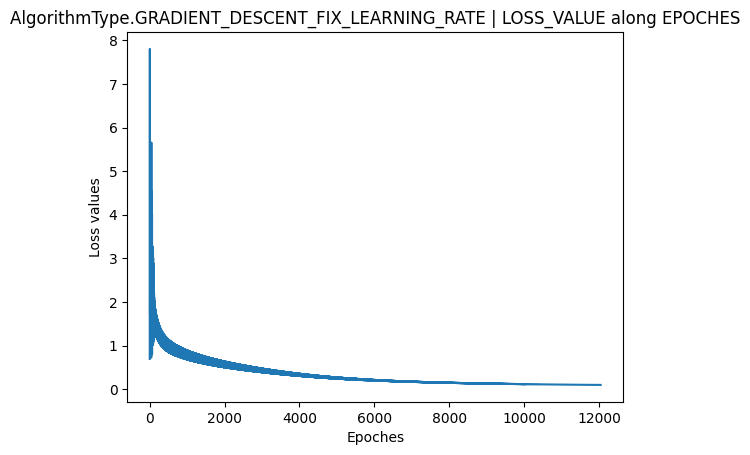

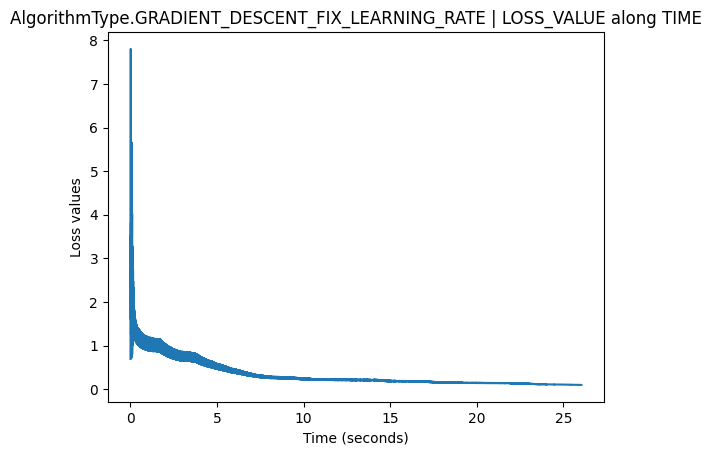

In [367]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1.23
MAX_EPOCHS = 15000
EPS = 1e-4

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [368]:
result_set.compile_dataframe()
BEST_GRADIENT_DESCENT_FIX_LEARNING_RATE = result_set.dataframe

In [382]:
BEST_EACH_ALGORITHM = pd.concat([BEST_EACH_ALGORITHM, BEST_GRADIENT_DESCENT_FIX_LEARNING_RATE])
BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
1,1,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.040819515516478], [0.46809166706685484], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.046976327896118164, 0.08815813064575195,...","[0.6931471805599466, 0.4949611332906602, 0.453...",267.037042,6854,0.075520
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.3061920294400973], [0.491527885491949], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.008510589599609375, 0.013521432876586914...","[0.6931471805599466, 2.6403091784287294, 3.802...",26.034524,12044,0.097012


STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Best loss values: 0.075520
Initial learning rate: 2.5
Number of epochs ran/Max epoches: 6854/10000
Runtime: 267.037042 seconds
Additional parameters: {'batch_size': 20, 'rule': 1, 'random_seed': 10}


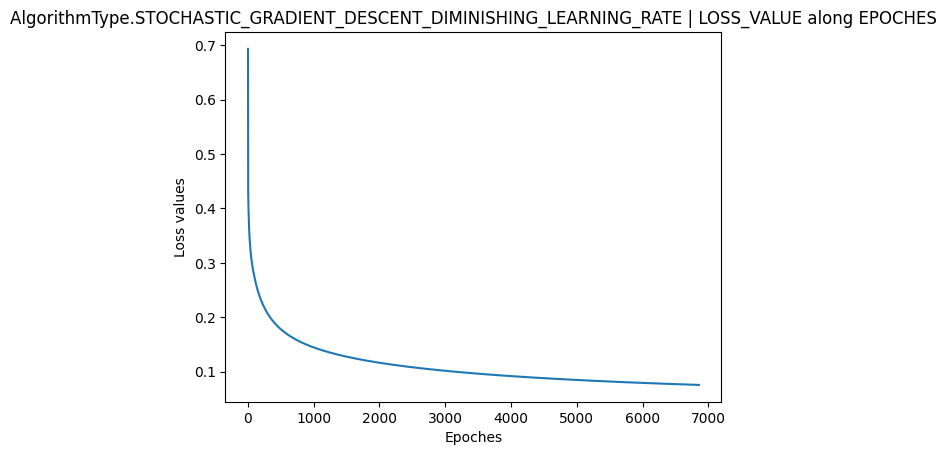

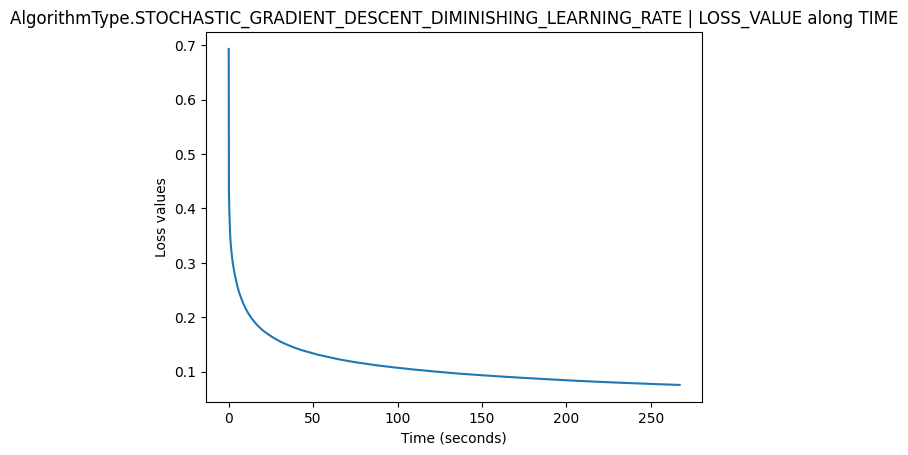

In [370]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.random.normal(0, 1, (Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 2.5
MAX_EPOCHS = 10000
EPS = 1e-4

BATCH_SIZE = 20
RULE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [374]:
result_set.compile_dataframe()
BEST_STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE = result_set.dataframe

In [375]:
BEST_EACH_ALGORITHM = pd.concat(
    [BEST_EACH_ALGORITHM, BEST_STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE]
)
BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,1,GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'alpha': 0.3, 'beta': 0.9}","[[0.015883947481124153], [0.049406811313008094...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04987382888793945, 0.08385658264160156, ...","[0.6931471805599457, 0.6488984264650429, 0.609...",428.657837,500,0.572825
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.3061920294400973], [0.491527885491949], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.008510589599609375, 0.013521432876586914...","[0.6931471805599466, 2.6403091784287294, 3.802...",26.034524,12044,0.097012
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.3061920294400973], [0.491527885491949], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.008510589599609375, 0.013521432876586914...","[0.6931471805599466, 2.6403091784287294, 3.802...",26.034524,12044,0.097012
1,1,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.040819515516478], [0.46809166706685484], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.046976327896118164, 0.08815813064575195,...","[0.6931471805599466, 0.4949611332906602, 0.453...",267.037042,6854,0.075520


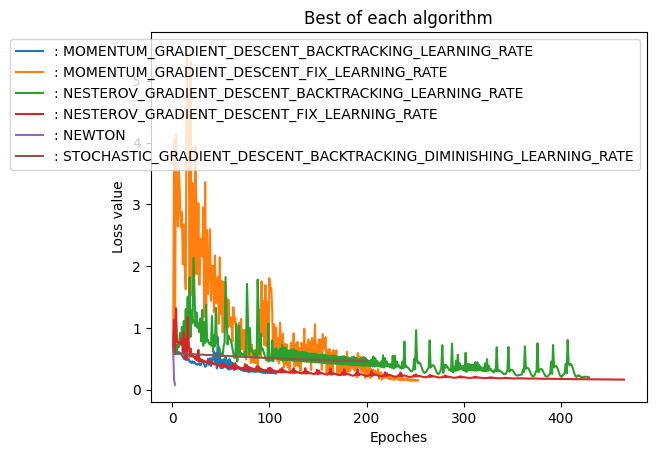

In [392]:
plot_graph(
    dataframe=BEST_EACH_ALGORITHM[:-2],
    x_axis_column="epoch_list",
    x_label="Epoches",
    y_axis_column="loss_value_epoch_list",
    y_label="Loss value",
    legend_column="algorithm_type",
    legend="",
    title="Best of each algorithm",
)

In [383]:
BEST_EACH_ALGORITHM

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
2,47,MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,300,0.0001,"{'gamma': 0.95, 'alpha': 0.05, 'beta': 0.95}","[[2.1097524567590273], [0.17279175840294272], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.1280663013458252, 0.23392248153686523, 0...","[0.6931471805599447, 0.6740258240566008, 0.616...",10.029732,107,0.285738
3,175,MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.900,500,0.0001,{'gamma': 0.95},"[[3.6987440400462654], [0.4957950755823449], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0020935535430908203, 0.00314307212829589...","[0.6931471805599447, 4.04214302632786, 0.99842...",0.412852,252,0.155477
4,98,NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.000,500,0.0001,"{'NAG_gamma': 0.9, 'alpha': 0.05, 'beta': 0.95}","[[4.44981624538309], [0.6592176695436618], [-0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.13211488723754883, 0.23245978355407715, ...","[0.6931471805599447, 0.6755255040766397, 0.595...",33.580274,428,0.198864
5,76,NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.500,500,0.0001,{'NAG_gamma': 0.95},"[[2.083229383637692], [0.42666149197574876], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.003972053527832031, 0.007052898406982422...","[0.6931471805599447, 1.123770735467877, 0.5765...",0.927163,464,0.162098
6,0,NEWTON,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.005,500,0.0001,{'test': 1},"[[1.533520419389049], [0.016924299805291754], ...","[1, 2, 3]","[0, 0.17216968536376953, 0.5719671249389648]","[0.6931471805599466, 0.15178594007974724, 0.07...",0.571967,2,0.076025
7,5,STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMIN...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",5.000,200,0.0001,"{'batch_size': 50, 'rule': 1, 'random_seed': 1...","[[0.5578658235088081], [0.6944193421447722], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.2846202850341797, 0.6020052433013916, 0....","[0.6931471805599447, 0.5878757302358987, 0.578...",150.515638,200,0.461892
1,1,STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNI...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",2.500,10000,0.0001,"{'batch_size': 20, 'rule': 1, 'random_seed': 10}","[[3.040819515516478], [0.46809166706685484], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.046976327896118164, 0.08815813064575195,...","[0.6931471805599466, 0.4949611332906602, 0.453...",267.037042,6854,0.075520
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.230,15000,0.0001,{},"[[2.3061920294400973], [0.491527885491949], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.008510589599609375, 0.013521432876586914...","[0.6931471805599466, 2.6403091784287294, 3.802...",26.034524,12044,0.097012


In [389]:
BEST_EACH_ALGORITHM.to_excel("best_each_algorithm.xlsx")